<a href="https://colab.research.google.com/github/bitanb1999/NLP_Univ_Project/blob/main/Abstractive_Summarisation_Finetuning_using_T5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstractive Text Summarisation using Finetuned T5 Model:

### **What is T5 model?**
T5, or Text-to-Text Transfer Transformer, is a Transformer based architecture that uses a text-to-text approach. Every task – including translation, question answering, and classification – is cast as feeding the model text as input and training it to generate some target text. This allows for the use of the same model, loss function, hyperparameters, etc. across our diverse set of tasks. The changes compared to BERT include:

adding a causal decoder to the bidirectional architecture.
replacing the fill-in-the-blank cloze task with a mix of alternative pre-training tasks.



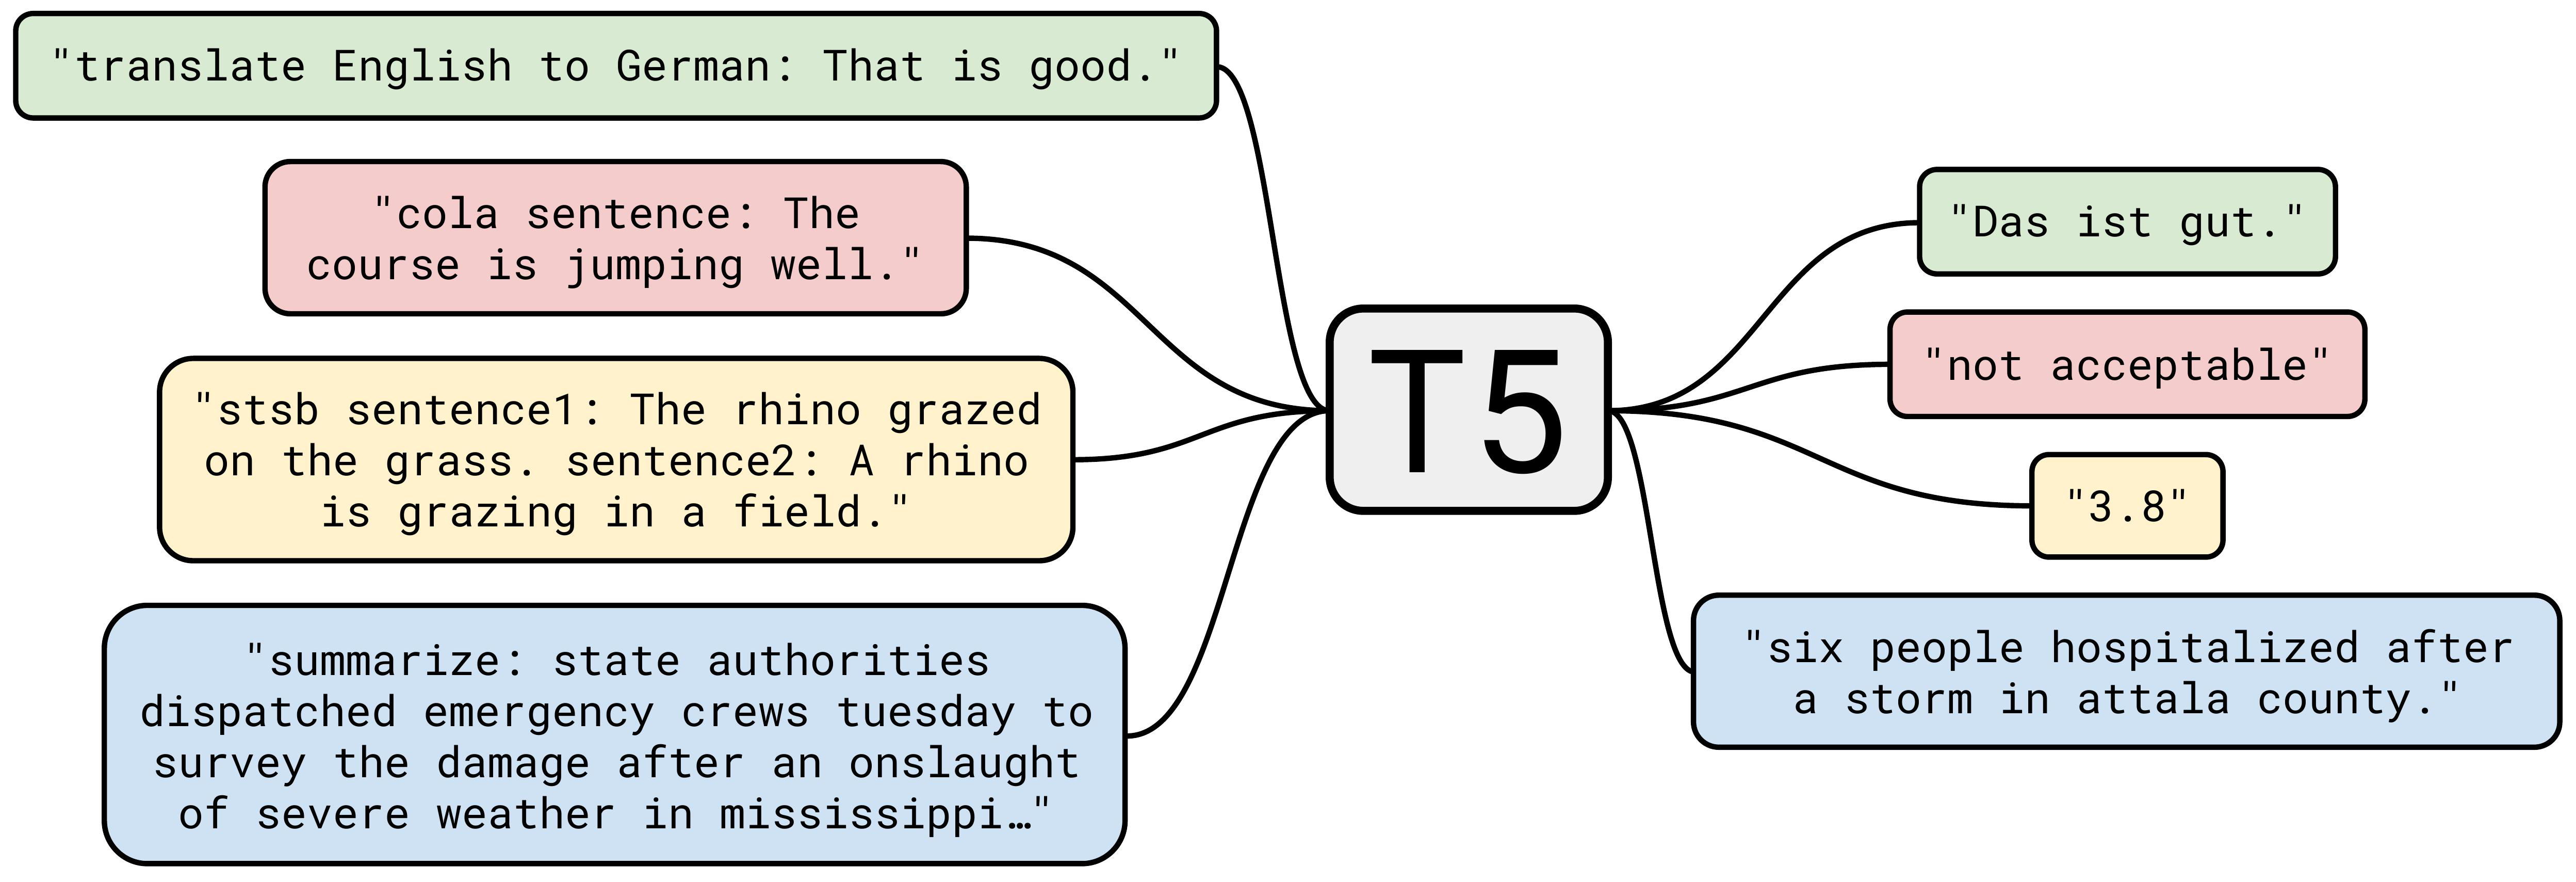

### **Why t5 for abstractive summarisation?**
T5 is an abstractive summarization algorithm. It means that it will rewrite sentences when necessary than just picking up sentences directly from the original text.

#### Requirements

In [ ]:
!pip install transformers==3.2.0
!pip install torch==1.4.0
!pip install pytorch_lightning==0.7.5 nlp datasets wandb -qU 
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import WandbLogger
from nlp import load_metric

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 7.2 MB/s 
     |████████████████████████████████| 1.2 MB 58.6 MB/s 
     |████████████████████████████████| 3.0 MB 72.0 MB/s 
     |████████████████████████████████| 880 kB 83.4 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=3a630b0c2233e5139505bac34f9ce45f41a8347a0c7e19b7a13b0dd41e3f0742
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 753.4 MB 6.5 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.0+cu113
    Uninstalling torch-1.12.0+cu113:
      Successfully uninstalled torch-1.12.0+cu113
ERROR: pip's dependency resolver does not curr

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
INFO:nlp.utils.file_utils:PyTorch version 1.4.0 available.
INFO:nlp.utils.file_utils:TensorFlow version 2.8.2 available.
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
## Login to WandB and get your API Key
import wandb
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### Dataset:

In [ ]:
!!wget https://notabug.org/yadnesh/wikihow_dataset/raw/master/wikihowAll.csv -P /root
from nlp import load_dataset
dataset = load_dataset('wikihow', 'all', data_dir='/root')

INFO:nlp.utils.file_utils:https://s3.amazonaws.com/datasets.huggingface.co/nlp/datasets/wikihow/wikihow.py not found in cache or force_download set to True, downloading to /root/.cache/huggingface/datasets/tmp2mu5_tuj


Downloading:   0%|          | 0.00/7.98k [00:00<?, ?B/s]

INFO:nlp.utils.file_utils:storing https://s3.amazonaws.com/datasets.huggingface.co/nlp/datasets/wikihow/wikihow.py in cache at /root/.cache/huggingface/datasets/2fb4405e098aa858131bbee2c9161e97c15ae930669cc9d85183a624a88a43c9.5271f500abcab0f8335a6e60a3f71efb7a454ab6038e6ca9d86fe5b557c19eea.py
INFO:nlp.utils.file_utils:creating metadata file for /root/.cache/huggingface/datasets/2fb4405e098aa858131bbee2c9161e97c15ae930669cc9d85183a624a88a43c9.5271f500abcab0f8335a6e60a3f71efb7a454ab6038e6ca9d86fe5b557c19eea.py
INFO:nlp.load:Checking /root/.cache/huggingface/datasets/2fb4405e098aa858131bbee2c9161e97c15ae930669cc9d85183a624a88a43c9.5271f500abcab0f8335a6e60a3f71efb7a454ab6038e6ca9d86fe5b557c19eea.py for additional imports.
INFO:nlp.load:Found main folder for dataset https://s3.amazonaws.com/datasets.huggingface.co/nlp/datasets/wikihow/wikihow.py at /usr/local/lib/python3.7/dist-packages/nlp/datasets/wikihow
INFO:nlp.load:Creating specific version folder for dataset https://s3.amazonaws.com/

INFO:nlp.utils.file_utils:https://raw.githubusercontent.com/mahnazkoupaee/WikiHow-Dataset/master/all_train.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/datasets/downloads/tmpbe0537i0


Downloading:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

INFO:nlp.utils.file_utils:storing https://raw.githubusercontent.com/mahnazkoupaee/WikiHow-Dataset/master/all_train.txt in cache at /root/.cache/huggingface/datasets/downloads/58a1449126c32956fd0580102161ba98937087fe690778fc5029be7ff2e47f3e.990bf204e700c6e9b06a8bc941583c62ff9c923ef0ce261bc6975b5dc835f7ab
INFO:nlp.utils.file_utils:creating metadata file for /root/.cache/huggingface/datasets/downloads/58a1449126c32956fd0580102161ba98937087fe690778fc5029be7ff2e47f3e.990bf204e700c6e9b06a8bc941583c62ff9c923ef0ce261bc6975b5dc835f7ab
INFO:nlp.utils.file_utils:https://raw.githubusercontent.com/mahnazkoupaee/WikiHow-Dataset/master/all_val.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/datasets/downloads/tmp9cw21b98


Downloading:   0%|          | 0.00/75.2k [00:00<?, ?B/s]

INFO:nlp.utils.file_utils:storing https://raw.githubusercontent.com/mahnazkoupaee/WikiHow-Dataset/master/all_val.txt in cache at /root/.cache/huggingface/datasets/downloads/0b00f12102df80bcb3a215ff5e63a7d82331fe5527b931f6beeb5cf1209983a7.3652c0058015166f45957b319edcd8818e5db0e8f9cd6d89bfa2427fedfbc845
INFO:nlp.utils.file_utils:creating metadata file for /root/.cache/huggingface/datasets/downloads/0b00f12102df80bcb3a215ff5e63a7d82331fe5527b931f6beeb5cf1209983a7.3652c0058015166f45957b319edcd8818e5db0e8f9cd6d89bfa2427fedfbc845
INFO:nlp.utils.file_utils:https://raw.githubusercontent.com/mahnazkoupaee/WikiHow-Dataset/master/all_test.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/datasets/downloads/tmpsiuee53b


Downloading:   0%|          | 0.00/75.2k [00:00<?, ?B/s]

INFO:nlp.utils.file_utils:storing https://raw.githubusercontent.com/mahnazkoupaee/WikiHow-Dataset/master/all_test.txt in cache at /root/.cache/huggingface/datasets/downloads/d58ecebabe3d69538424ca2dd1d82ee818623c5aa4c26c51093f7cae06045a9b.09b3aa4afd01c9a90ccc3242e0d1d149e43300bd00d267c3d06cfd4c14891783
INFO:nlp.utils.file_utils:creating metadata file for /root/.cache/huggingface/datasets/downloads/d58ecebabe3d69538424ca2dd1d82ee818623c5aa4c26c51093f7cae06045a9b.09b3aa4afd01c9a90ccc3242e0d1d149e43300bd00d267c3d06cfd4c14891783
INFO:nlp.utils.info_utils:Unable to verify checksums.
INFO:nlp.builder:Generating split train


0 examples [00:00, ? examples/s]

INFO:nlp.arrow_writer:Done writing 157252 examples in 513238309 bytes /root/.cache/huggingface/datasets/wikihow/all/1.2.0/cfb412ca2191fac028cae9a5a9a03ba21b08ff2b4bf46f8a0473d7303a3e3683.incomplete/wikihow-train.arrow.
INFO:nlp.builder:Generating split validation


0 examples [00:00, ? examples/s]

INFO:nlp.arrow_writer:Done writing 5599 examples in 18246897 bytes /root/.cache/huggingface/datasets/wikihow/all/1.2.0/cfb412ca2191fac028cae9a5a9a03ba21b08ff2b4bf46f8a0473d7303a3e3683.incomplete/wikihow-validation.arrow.
INFO:nlp.builder:Generating split test


0 examples [00:00, ? examples/s]

INFO:nlp.arrow_writer:Done writing 5577 examples in 18276023 bytes /root/.cache/huggingface/datasets/wikihow/all/1.2.0/cfb412ca2191fac028cae9a5a9a03ba21b08ff2b4bf46f8a0473d7303a3e3683.incomplete/wikihow-test.arrow.
INFO:nlp.utils.info_utils:Unable to verify splits sizes.
INFO:nlp.builder:Constructing Dataset for split train, validation, test, from /root/.cache/huggingface/datasets/wikihow/all/1.2.0/cfb412ca2191fac028cae9a5a9a03ba21b08ff2b4bf46f8a0473d7303a3e3683
INFO:nlp.utils.info_utils:Unable to verify checksums.
INFO:nlp.utils.info_utils:Unable to verify checksums.
INFO:nlp.utils.info_utils:Unable to verify checksums.


Dataset wikihow downloaded and prepared to /root/.cache/huggingface/datasets/wikihow/all/1.2.0/cfb412ca2191fac028cae9a5a9a03ba21b08ff2b4bf46f8a0473d7303a3e3683. Subsequent calls will reuse this data.


In [ ]:
#estimating the average text length and summary
tiny_dataset = dataset['train'].select(list(range(0, 100)))
text_len = []
summary_len=[]

INFO:nlp.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/wikihow/all/1.2.0/cfb412ca2191fac028cae9a5a9a03ba21b08ff2b4bf46f8a0473d7303a3e3683/cache-2c17c60cc82b5df3d342a4f28070e1bd.arrow


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:nlp.arrow_writer:Done writing 100 examples in 410735 bytes /root/.cache/huggingface/datasets/wikihow/all/1.2.0/cfb412ca2191fac028cae9a5a9a03ba21b08ff2b4bf46f8a0473d7303a3e3683/tmpngdh3r8r.


In [ ]:
for i in range(len(tiny_dataset)):
    example = tiny_dataset[i]
    text_example = example['text']
    text_example = text_example.replace('\n','')
    text_words = text_example.split()
    text_len.append(len(text_words))
    summary_example = example['headline']
    summary_example = summary_example.replace('\n','')
    summary_words = summary_example.split()
    summary_len.append(len(summary_words))

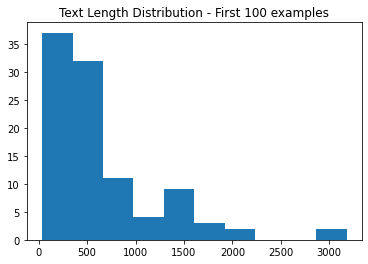

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(text_len)
plt.title('Text Length Distribution - First 100 examples')
plt.show()

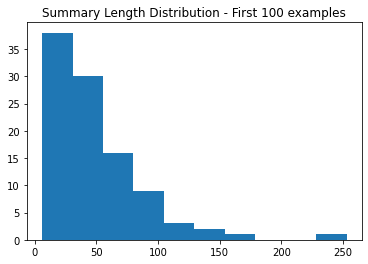

In [ ]:
plt.hist(summary_len)
plt.title('Summary Length Distribution - First 100 examples')
plt.show()

In [ ]:
print("Average Length of Summary: ", sum(summary_len)/len(summary_len))
print("Average Length of text: ", sum(text_len)/len(text_len))

Average Length of Summary:  48.8
Average Length of text:  662.69


### Modeling:

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [ ]:
class T5FineTuner(pl.LightningModule):
  #initialising with the hyperparameters for finetuning and metric rouge score
    def __init__(self, hparams):
        super(T5FineTuner, self).__init__()
        self.hparams = hparams        
        self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
        self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
        self.rouge_metric = load_metric('rouge') 
  #freezing params      
        if self.hparams.freeze_embeds:
            self.freeze_embeds()
        if self.hparams.freeze_encoder:
            self.freeze_params(self.model.get_encoder())
            assert_all_frozen(self.model.get_encoder())
            
            
        n_observations_per_split = {
            "train": self.hparams.n_train,
            "validation": self.hparams.n_val,
            "test": self.hparams.n_test,
        }
        self.n_obs = {k: v if v >= 0 else None for k, v in n_observations_per_split.items()}
        
    
    def freeze_params(self, model):
        for par in model.parameters():
            par.requires_grad = False
            
  #helper code for freezing embeddings for transformers from hugging face repositiory          
    def freeze_embeds(self):
        """Freeze token embeddings and positional embeddings for bart, just token embeddings for t5."""
        try:
            self.freeze_params(self.model.model.shared)
            for d in [self.model.model.encoder, self.model.model.decoder]:
                freeze_params(d.embed_positions)
                freeze_params(d.embed_tokens)
        except AttributeError:
            self.freeze_params(self.model.shared)
            for d in [self.model.encoder, self.model.decoder]:
                self.freeze_params(d.embed_tokens)
    
    def lmap(self, f, x):
        """list(map(f, x))"""
        return list(map(f, x))
    

    def is_logger(self):
        return self.trainer.proc_rank <= 0
    
  #keeping track of only the fmeasure from rouge score
    def parse_score(self, result):
        return {k: round(v.mid.fmeasure * 100, 4) for k, v in result.items()}
  #for the feedforward      
    def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            lm_labels=lm_labels,
    )

    def _step(self, batch):
        lm_labels = batch["target_ids"]
        lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

        outputs = self(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            lm_labels=lm_labels,
            decoder_attention_mask=batch['target_mask']
        )

        loss = outputs[0]

        return loss
    
#text cleaning    
    def ids_to_clean_text(self, generated_ids):
        gen_text = self.tokenizer.batch_decode(
            generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
        )
        return self.lmap(str.strip, gen_text)
    
    
    def _generative_step(self, batch) :
        
        t0 = time.time()
        
        generated_ids = self.model.generate(
            batch["source_ids"],
            attention_mask=batch["source_mask"],
            use_cache=True,
            decoder_attention_mask=batch['target_mask'],
            max_length=150, 
            num_beams=2,
            repetition_penalty=2.5, 
            length_penalty=1.0, 
            early_stopping=True
        )
        preds = self.ids_to_clean_text(generated_ids)
        target = self.ids_to_clean_text(batch["target_ids"])
            
        gen_time = (time.time() - t0) / batch["source_ids"].shape[0]  
    
        loss = self._step(batch)
        base_metrics = {'val_loss': loss}
#         rouge: Dict = self.calc_generative_metrics(preds, target)
        summ_len = np.mean(self.lmap(len, generated_ids))
        base_metrics.update(gen_time=gen_time, gen_len=summ_len, preds=preds, target=target)
        self.rouge_metric.add_batch(preds, target)
        
#         rouge_results = self.rouge_metric.compute() 
#         rouge_dict = self.parse_score(rouge_results)
#         base_metrics.update(rouge1=rouge_dict['rouge1'], rougeL=rouge_dict['rougeL'])
        
        return base_metrics
    

    def training_step(self, batch, batch_idx):
        loss = self._step(batch)
        tensorboard_logs = {"train_loss": loss}
        return {"loss": loss, "log": tensorboard_logs}
    def test_step(self, batch, batch_idx):
        loss = self._step(batch)
        tensorboard_logs = {"test_loss": loss}
        return {"test_loss": loss, "test_log": tensorboard_logs}
    def training_epoch_end(self, outputs):
        avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
        tensorboard_logs = {"avg_train_loss": avg_train_loss}
        return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        return self._generative_step(batch)
    
  
    def validation_epoch_end(self, outputs):
        
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        tensorboard_logs = {"val_loss": avg_loss}
        
        rouge_results = self.rouge_metric.compute() 
        rouge_dict = self.parse_score(rouge_results)
    
        tensorboard_logs.update(rouge1=rouge_dict['rouge1'], rougeL=rouge_dict['rougeL'])
        
        ## Clear out the lists for next epoch
        self.target_gen= []
        self.prediction_gen=[]
        return {"avg_val_loss": avg_loss, 
                "rouge1" : rouge_results['rouge1'],
                "rougeL" : rouge_results['rougeL'],
                "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

    def configure_optimizers(self):
        "Prepare optimizer and schedule (linear warmup and decay)"

        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
        self.opt = optimizer
        return [optimizer]
    def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None, using_native_amp=False):
        if self.trainer.use_tpu:
            xm.optimizer_step(optimizer)
        else:
            optimizer.step()
        optimizer.zero_grad()
        self.lr_scheduler.step()
  
    def get_tqdm_dict(self):
        tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

        return tqdm_dict
    
#creating pytorch datasets using DataLoader and preparing for training
    def train_dataloader(self):   
        n_samples = self.n_obs['train']
        train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", num_samples=n_samples, args=self.hparams)
        dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
        t_total = (
            (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
            // self.hparams.gradient_accumulation_steps
            * float(self.hparams.num_train_epochs)
        )
        scheduler = get_linear_schedule_with_warmup(
            self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
        )
        self.lr_scheduler = scheduler
        return dataloader

    def val_dataloader(self):
        n_samples = self.n_obs['validation']
        validation_dataset = get_dataset(tokenizer=self.tokenizer, type_path="validation", num_samples=n_samples, args=self.hparams)
        
        return DataLoader(validation_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)
    
    
    def test_dataloader(self):
        n_samples = self.n_obs['test']
        test_dataset = get_dataset(tokenizer=self.tokenizer, type_path="test", num_samples=n_samples, args=self.hparams)
        
        return DataLoader(test_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

In [ ]:
#pytorch callbacks
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
    def on_validation_end(self, trainer, pl_module):
        logger.info("***** Validation results *****")
        if pl_module.is_logger():
            metrics = trainer.callback_metrics
            # Log results
            for key in sorted(metrics):
                if key not in ["log", "progress_bar"]:
                    logger.info("{} = {}\n".format(key, str(metrics[key])))

    def on_test_end(self, trainer, pl_module):
        logger.info("***** Test results *****")

        if pl_module.is_logger():
            metrics = trainer.callback_metrics

            # Log and save results to file
            output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
            with open(output_test_results_file, "w") as writer:
                for key in sorted(metrics):
                    if key not in ["log", "progress_bar"]:
                        logger.info("{} = {}\n".format(key, str(metrics[key])))
                        writer.write("{} = {}\n".format(key, str(metrics[key])))

### Pytorch DataLoader for the model


In [ ]:
class wikihow(Dataset):
    def __init__(self, tokenizer, type_path, num_samples, input_length, output_length, print_text=False):         
        self.dataset =  load_dataset('wikihow', 'all', data_dir='data/', split=type_path)
        if num_samples:
            self.dataset = self.dataset.select(list(range(0, num_samples)))
        self.input_length = input_length
        self.tokenizer = tokenizer
        self.output_length = output_length
        self.print_text = print_text
  
    def __len__(self):
        return self.dataset.shape[0]
    
    def clean_text(self, text):
        text = text.replace('Example of text:', '')
        text = text.replace('Example of Summary:', '')
        text = text.replace('\n','')
        text = text.replace('``', '')
        text = text.replace('"', '')
        
        return text
    
    
    def convert_to_features(self, example_batch):
        # Tokenize contexts and questions (as pairs of inputs)
        
        if self.print_text:
            print("Input Text: ", self.clean_text(example_batch['text']))
#         input_ = self.clean_text(example_batch['text']) + " </s>"
#         target_ = self.clean_text(example_batch['headline']) + " </s>"
        
        input_ = self.clean_text(example_batch['text'])
        target_ = self.clean_text(example_batch['headline'])
        
        source = self.tokenizer.batch_encode_plus([input_], max_length=self.input_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")
        
        targets = self.tokenizer.batch_encode_plus([target_], max_length=self.output_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")
    
       
        return source, targets
  
    def __getitem__(self, index):
        source, targets = self.convert_to_features(self.dataset[index])
        
        source_ids = source["input_ids"].squeeze()
        target_ids = targets["input_ids"].squeeze()

        src_mask    = source["attention_mask"].squeeze()
        target_mask = targets["attention_mask"].squeeze()

        return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
        
  

### Dataset Testing:

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
tokenizer = T5Tokenizer.from_pretrained('t5-small')
dataset = wikihow(tokenizer, 'validation', None, 512, 150, True)
len(dataset)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

INFO:nlp.load:Checking /root/.cache/huggingface/datasets/2fb4405e098aa858131bbee2c9161e97c15ae930669cc9d85183a624a88a43c9.5271f500abcab0f8335a6e60a3f71efb7a454ab6038e6ca9d86fe5b557c19eea.py for additional imports.
INFO:nlp.load:Found main folder for dataset https://s3.amazonaws.com/datasets.huggingface.co/nlp/datasets/wikihow/wikihow.py at /usr/local/lib/python3.7/dist-packages/nlp/datasets/wikihow
INFO:nlp.load:Found specific version folder for dataset https://s3.amazonaws.com/datasets.huggingface.co/nlp/datasets/wikihow/wikihow.py at /usr/local/lib/python3.7/dist-packages/nlp/datasets/wikihow/cfb412ca2191fac028cae9a5a9a03ba21b08ff2b4bf46f8a0473d7303a3e3683
INFO:nlp.load:Found script file from https://s3.amazonaws.com/datasets.huggingface.co/nlp/datasets/wikihow/wikihow.py to /usr/local/lib/python3.7/dist-packages/nlp/datasets/wikihow/cfb412ca2191fac028cae9a5a9a03ba21b08ff2b4bf46f8a0473d7303a3e3683/wikihow.py
INFO:nlp.load:Couldn't find dataset infos file at https://s3.amazonaws.com/d

5599

In [ ]:
data = dataset[50]
print()
print("Shape of Tokenized Text: ", data['source_ids'].shape)
print()
print("Sanity check - Decode Text: ", tokenizer.decode(data['source_ids']))
print("====================================")
print("Sanity check - Decode Summary: ", tokenizer.decode(data['target_ids']))

Input Text:  You can use a smaller size (3/4 inch is used here), but it won't be as strong.;, Be sure that the feet are headed in the same direction and the shape is as squared as you can get it. It is very easy to get turned around. You want it to shrink somewhat (like it would naturally) before you affix it to the frame.If you are going to be making a quilted bed, do what you need to, to get it ready. The soft part of this setup is a small velour blanket folded into quarters., You could use rivets, snaps, hooks, even Velcro. Keep in mind that you are going to have to clean it periodically.A particularly easy method is to sew the material around the sides, but you won't be able to glue the legs to the corner ends, completely.

Shape of Tokenized Text:  torch.Size([512])

Sanity check - Decode Text:  You can use a smaller size (3/4 inch is used here), but it won't be as strong.;, Be sure that the feet are headed in the same direction and the shape is as squared as you can get it. It is

### Train:

In [ ]:

args_dict = dict(
    output_dir="/content/wandb", # path to save the checkpoints
    model_name_or_path='t5-small',
    tokenizer_name_or_path='t5-small',
    max_input_length=512,
    max_output_length=150,
    freeze_encoder=False,
    freeze_embeds=False,
    learning_rate=3e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=4,
    eval_batch_size=4,
    num_train_epochs=2,
    gradient_accumulation_steps=8,
    n_gpu=1,
    resume_from_checkpoint=None, 
    val_check_interval = 0.05, 
    n_val=1000,
    n_train=-1,
    n_test=-1,
    early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42,
)

In [ ]:
args_dict.update({'output_dir': 'contents', 'num_train_epochs':2,
                 'train_batch_size': 4, 'eval_batch_size': 4})
args = argparse.Namespace(**args_dict)
print(args_dict)

{'output_dir': 'contents', 'model_name_or_path': 't5-small', 'tokenizer_name_or_path': 't5-small', 'max_input_length': 512, 'max_output_length': 150, 'freeze_encoder': False, 'freeze_embeds': False, 'learning_rate': 0.0003, 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'warmup_steps': 0, 'train_batch_size': 4, 'eval_batch_size': 4, 'num_train_epochs': 2, 'gradient_accumulation_steps': 8, 'n_gpu': 1, 'resume_from_checkpoint': None, 'val_check_interval': 0.05, 'n_val': 1000, 'n_train': -1, 'n_test': -1, 'early_stop_callback': False, 'fp_16': False, 'opt_level': 'O1', 'max_grad_norm': 1.0, 'seed': 42}


In [ ]:
import wandb
YOUR_API_KEY = 'e09166ef971596ed3beab116d40e00c77e090fd5'
os.environ["WANDB_API_KEY"] = YOUR_API_KEY
wandb_logger = WandbLogger(project='wikohow-t5')

In [ ]:
#checkpoint_callback = pl.callbacks.ModelCheckpoint(filepath=args.output_dir,prefix="checkpoint", monitor="val_loss", mode="min", save_top_k=3)

## If resuming from checkpoint, add an arg resume_from_checkpoint
train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    resume_from_checkpoint=args.resume_from_checkpoint,
    gradient_clip_val=args.max_grad_norm,
    val_check_interval=args.val_check_interval,
    logger=wandb_logger,
    callbacks=[LoggingCallback()],
)

In [ ]:
def get_dataset(tokenizer, type_path, num_samples, args):
      return wikihow(tokenizer=tokenizer, type_path=type_path, num_samples=num_samples,  input_length=args.max_input_length, 
                        output_length=args.max_output_length)

In [ ]:
!pip install rouge_score rouge_score
model = T5FineTuner(args)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=c5dbd16d28847c958154ad5dc3a0a445d4af8760ea8365a51924f7516e954bdf
  Stored in directory: /root/.cache/pip/wheels/84/ac/6b/38096e3c5bf1dc87911e3585875e21a3ac610348e740409c76
Successfully built rouge-score


Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/242M [00:00<?, ?B/s]

INFO:nlp.utils.file_utils:https://s3.amazonaws.com/datasets.huggingface.co/nlp/metrics/rouge/rouge.py not found in cache or force_download set to True, downloading to /root/.cache/huggingface/datasets/tmpbpsf67ls


Downloading:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

INFO:nlp.utils.file_utils:storing https://s3.amazonaws.com/datasets.huggingface.co/nlp/metrics/rouge/rouge.py in cache at /root/.cache/huggingface/datasets/5ecb6e4b474317b41ae1fe5d702d1af8d86d452f0b1d70f77a12f6f014ded6ac.35bc2c477aa456d2f589656477ccb0b463c21cdfb83a9de86d63de8560a96d1b.py
INFO:nlp.utils.file_utils:creating metadata file for /root/.cache/huggingface/datasets/5ecb6e4b474317b41ae1fe5d702d1af8d86d452f0b1d70f77a12f6f014ded6ac.35bc2c477aa456d2f589656477ccb0b463c21cdfb83a9de86d63de8560a96d1b.py
INFO:nlp.load:Checking /root/.cache/huggingface/datasets/5ecb6e4b474317b41ae1fe5d702d1af8d86d452f0b1d70f77a12f6f014ded6ac.35bc2c477aa456d2f589656477ccb0b463c21cdfb83a9de86d63de8560a96d1b.py for additional imports.
INFO:nlp.load:Found main folder for metric https://s3.amazonaws.com/datasets.huggingface.co/nlp/metrics/rouge/rouge.py at /usr/local/lib/python3.7/dist-packages/nlp/metrics/rouge
INFO:nlp.load:Found specific version folder for metric https://s3.amazonaws.com/datasets.huggingfa

In [ ]:
trainer = pl.Trainer(**train_params)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


In [ ]:
trainer.fit(model)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `test_dataloader()` and have defined a `test_step()`, you may also want to define `test_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
wandb: Currently logged in as: bitanb99. Use `wandb login --relogin` to force relogin


INFO:lightning:
    | Name                                                                  | Type                       | Params
-----------------------------------------------------------------------------------------------------------------
0   | model                                                                 | T5ForConditionalGeneration | 60 M  
1   | model.shared                                                          | Embedding                  | 16 M  
2   | model.encoder                                                         | T5Stack                    | 35 M  
3   | model.encoder.block                                                   | ModuleList                 | 18 M  
4   | model.encoder.block.0                                                 | T5Block                    | 3 M   
5   | model.encoder.block.0.layer                                           | ModuleList                 | 3 M   
6   | model.encoder.block.0.layer.0                                     

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 3473675 bytes /root/.cache/huggingface/datasets/wikihow/all/1.2.0/cfb412ca2191fac028cae9a5a9a03ba21b08ff2b4bf46f8a0473d7303a3e3683/tmputvhjt_q.


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/modeling_t5.py:1128: FutureWarning: The `lm_labels` argument is deprecated and will be removed in a future version, use `labels` instead.
  FutureWarning,
INFO:nlp.arrow_writer:Done writing 20 examples in 11677 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:nlp.load:Checking /root/.cache/huggingface/datasets/2fb4405e098aa858131bbee2c9161e97c15ae930669cc9d85183a624a88a43c9.5271f500abcab0f8335a6e60a3f71efb7a454ab6038e6ca9d86fe5b557c19eea.py for additional imports.
INFO:nlp.load:Found main folder for dataset https://s3.amazonaws.com/datasets.huggingface.co/nlp/datasets/wikihow/wikihow.py at /usr/local/lib/python3.7/dist-packages/nlp/datasets/

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 391993 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(2.6793, device='cuda:0')

INFO:__main__:loss = tensor(3.1408, device='cuda:0')

INFO:__main__:rouge1 = 26.5544

INFO:__main__:rougeL = 20.402

INFO:__main__:train_loss = tensor(3.1408, device='cuda:0')

INFO:__main__:val_loss = tensor(2.6793, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 387510 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(2.6112, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(2.9824, device='cuda:0')

INFO:__main__:rouge1 = 26.6997

INFO:__main__:rougeL = 20.6624

INFO:__main__:train_loss = tensor(2.9824, device='cuda:0')

INFO:__main__:val_loss = tensor(2.6112, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 400970 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(2.5726, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(2.5956, device='cuda:0')

INFO:__main__:rouge1 = 28.2063

INFO:__main__:rougeL = 21.7114

INFO:__main__:train_loss = tensor(2.5956, device='cuda:0')

INFO:__main__:val_loss = tensor(2.5726, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 392890 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(2.5477, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(2.6497, device='cuda:0')

INFO:__main__:rouge1 = 28.4012

INFO:__main__:rougeL = 21.8832

INFO:__main__:train_loss = tensor(2.6497, device='cuda:0')

INFO:__main__:val_loss = tensor(2.5477, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 402451 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(2.5265, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(3.0765, device='cuda:0')

INFO:__main__:rouge1 = 28.8815

INFO:__main__:rougeL = 22.4456

INFO:__main__:train_loss = tensor(3.0765, device='cuda:0')

INFO:__main__:val_loss = tensor(2.5265, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 405478 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(2.5122, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(3.2408, device='cuda:0')

INFO:__main__:rouge1 = 29.2515

INFO:__main__:rougeL = 22.4088

INFO:__main__:train_loss = tensor(3.2408, device='cuda:0')

INFO:__main__:val_loss = tensor(2.5122, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 400599 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(2.4978, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(3.3582, device='cuda:0')

INFO:__main__:rouge1 = 29.263

INFO:__main__:rougeL = 22.8133

INFO:__main__:train_loss = tensor(3.3582, device='cuda:0')

INFO:__main__:val_loss = tensor(2.4978, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 399765 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(2.4840, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(2.6204, device='cuda:0')

INFO:__main__:rouge1 = 29.6852

INFO:__main__:rougeL = 22.9874

INFO:__main__:train_loss = tensor(2.6204, device='cuda:0')

INFO:__main__:val_loss = tensor(2.4840, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 390761 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(2.4808, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(2.7051, device='cuda:0')

INFO:__main__:rouge1 = 28.8813

INFO:__main__:rougeL = 22.6746

INFO:__main__:train_loss = tensor(2.7051, device='cuda:0')

INFO:__main__:val_loss = tensor(2.4808, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 400757 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(2.4633, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(2.9206, device='cuda:0')

INFO:__main__:rouge1 = 29.6805

INFO:__main__:rougeL = 23.1561

INFO:__main__:train_loss = tensor(2.9206, device='cuda:0')

INFO:__main__:val_loss = tensor(2.4633, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 397946 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(2.4574, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(2.2209, device='cuda:0')

INFO:__main__:rouge1 = 29.7476

INFO:__main__:rougeL = 23.2122

INFO:__main__:train_loss = tensor(2.2209, device='cuda:0')

INFO:__main__:val_loss = tensor(2.4574, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 401403 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(2.4482, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(3.2931, device='cuda:0')

INFO:__main__:rouge1 = 29.6802

INFO:__main__:rougeL = 23.1553

INFO:__main__:train_loss = tensor(3.2931, device='cuda:0')

INFO:__main__:val_loss = tensor(2.4482, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 411168 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(2.4446, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(1.8865, device='cuda:0')

INFO:__main__:rouge1 = 30.1269

INFO:__main__:rougeL = 23.2782

INFO:__main__:train_loss = tensor(1.8865, device='cuda:0')

INFO:__main__:val_loss = tensor(2.4446, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 405058 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(2.4333, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(2.6199, device='cuda:0')

INFO:__main__:rouge1 = 30.3614

INFO:__main__:rougeL = 23.518

INFO:__main__:train_loss = tensor(2.6199, device='cuda:0')

INFO:__main__:val_loss = tensor(2.4333, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 399145 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(2.4313, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(2.7175, device='cuda:0')

INFO:__main__:rouge1 = 29.7935

INFO:__main__:rougeL = 23.3543

INFO:__main__:train_loss = tensor(2.7175, device='cuda:0')

INFO:__main__:val_loss = tensor(2.4313, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 405519 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(2.4230, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(2.9492, device='cuda:0')

INFO:__main__:rouge1 = 30.4707

INFO:__main__:rougeL = 23.6728

INFO:__main__:train_loss = tensor(2.9492, device='cuda:0')

INFO:__main__:val_loss = tensor(2.4230, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 405094 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(2.4199, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(2.5880, device='cuda:0')

INFO:__main__:rouge1 = 30.4659

INFO:__main__:rougeL = 23.6818

INFO:__main__:train_loss = tensor(2.5880, device='cuda:0')

INFO:__main__:val_loss = tensor(2.4199, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 405433 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(2.4129, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(3.5021, device='cuda:0')

INFO:__main__:rouge1 = 30.4823

INFO:__main__:rougeL = 23.6612

INFO:__main__:train_loss = tensor(3.5021, device='cuda:0')

INFO:__main__:val_loss = tensor(2.4129, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 399996 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(2.4085, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(2.9383, device='cuda:0')

INFO:__main__:rouge1 = 30.6703

INFO:__main__:rougeL = 23.9651

INFO:__main__:train_loss = tensor(2.9383, device='cuda:0')

INFO:__main__:val_loss = tensor(2.4085, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 404322 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(2.4022, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(2.2065, device='cuda:0')

INFO:__main__:rouge1 = 30.5541

INFO:__main__:rougeL = 23.8118

INFO:__main__:train_loss = tensor(2.2065, device='cuda:0')

INFO:__main__:val_loss = tensor(2.4022, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 409300 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(2.6839, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(2.4008, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(2.5721, device='cuda:0')

INFO:__main__:rouge1 = 30.8847

INFO:__main__:rougeL = 24.1011

INFO:__main__:train_loss = tensor(2.5721, device='cuda:0')

INFO:__main__:val_loss = tensor(2.4008, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 408191 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(2.6839, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(2.3976, device='cuda:0')

INFO:__main__:epoch = 1

INFO:__main__:loss = tensor(3.0419, device='cuda:0')

INFO:__main__:rouge1 = 30.8639

INFO:__main__:rougeL = 24.0632

INFO:__main__:train_loss = tensor(3.0419, device='cuda:0')

INFO:__main__:val_loss = tensor(2.3976, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 405775 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(2.6839, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(2.3978, device='cuda:0')

INFO:__main__:epoch = 1

INFO:__main__:loss = tensor(2.3949, device='cuda:0')

INFO:__main__:rouge1 = 30.5624

INFO:__main__:rougeL = 23.8584

INFO:__main__:train_loss = tensor(2.3949, device='cuda:0')

INFO:__main__:val_loss = tensor(2.3978, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 410780 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(2.6839, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(2.3939, device='cuda:0')

INFO:__main__:epoch = 1

INFO:__main__:loss = tensor(2.2411, device='cuda:0')

INFO:__main__:rouge1 = 31.123

INFO:__main__:rougeL = 24.1547

INFO:__main__:train_loss = tensor(2.2411, device='cuda:0')

INFO:__main__:val_loss = tensor(2.3939, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 407680 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(2.6839, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(2.3908, device='cuda:0')

INFO:__main__:epoch = 1

INFO:__main__:loss = tensor(2.7800, device='cuda:0')

INFO:__main__:rouge1 = 31.0075

INFO:__main__:rougeL = 23.9838

INFO:__main__:train_loss = tensor(2.7800, device='cuda:0')

INFO:__main__:val_loss = tensor(2.3908, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 401531 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(2.6839, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(2.3871, device='cuda:0')

INFO:__main__:epoch = 1

INFO:__main__:loss = tensor(2.6105, device='cuda:0')

INFO:__main__:rouge1 = 30.4917

INFO:__main__:rougeL = 23.7547

INFO:__main__:train_loss = tensor(2.6105, device='cuda:0')

INFO:__main__:val_loss = tensor(2.3871, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 406818 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(2.6839, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(2.3898, device='cuda:0')

INFO:__main__:epoch = 1

INFO:__main__:loss = tensor(2.4024, device='cuda:0')

INFO:__main__:rouge1 = 30.6888

INFO:__main__:rougeL = 24.006

INFO:__main__:train_loss = tensor(2.4024, device='cuda:0')

INFO:__main__:val_loss = tensor(2.3898, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 402548 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(2.6839, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(2.3831, device='cuda:0')

INFO:__main__:epoch = 1

INFO:__main__:loss = tensor(2.1761, device='cuda:0')

INFO:__main__:rouge1 = 30.6112

INFO:__main__:rougeL = 24.0712

INFO:__main__:train_loss = tensor(2.1761, device='cuda:0')

INFO:__main__:val_loss = tensor(2.3831, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 406209 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(2.6839, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(2.3859, device='cuda:0')

INFO:__main__:epoch = 1

INFO:__main__:loss = tensor(2.0475, device='cuda:0')

INFO:__main__:rouge1 = 30.9111

INFO:__main__:rougeL = 24.098

INFO:__main__:train_loss = tensor(2.0475, device='cuda:0')

INFO:__main__:val_loss = tensor(2.3859, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 413103 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(2.6839, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(2.3776, device='cuda:0')

INFO:__main__:epoch = 1

INFO:__main__:loss = tensor(3.0061, device='cuda:0')

INFO:__main__:rouge1 = 31.1225

INFO:__main__:rougeL = 24.1846

INFO:__main__:train_loss = tensor(3.0061, device='cuda:0')

INFO:__main__:val_loss = tensor(2.3776, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 411013 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(2.6839, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(2.3764, device='cuda:0')

INFO:__main__:epoch = 1

INFO:__main__:loss = tensor(1.7597, device='cuda:0')

INFO:__main__:rouge1 = 31.1716

INFO:__main__:rougeL = 24.2474

INFO:__main__:train_loss = tensor(1.7597, device='cuda:0')

INFO:__main__:val_loss = tensor(2.3764, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 410488 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(2.6839, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(2.3765, device='cuda:0')

INFO:__main__:epoch = 1

INFO:__main__:loss = tensor(2.4729, device='cuda:0')

INFO:__main__:rouge1 = 31.3391

INFO:__main__:rougeL = 24.2558

INFO:__main__:train_loss = tensor(2.4729, device='cuda:0')

INFO:__main__:val_loss = tensor(2.3765, device='cuda:0')



Validating: 0it [00:00, ?it/s]

INFO:nlp.arrow_writer:Done writing 1000 examples in 409121 bytes /root/.cache/huggingface/metrics/rouge/default/1.0.0/06783dbed5f6b6a5413f84d2a5f0d9dc9cb871f1aeb3787f2c90a8e3fe60b1c1/cache-rouge-0.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to python objects for no columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:absl:Using default tokenizer.
INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(2.6839, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(2.3750, device='cuda:0')

INFO:__main__:epoch = 1

INFO:__main__:loss = tensor(3.3232, device='cuda:0')

INFO:__main__:rouge1 = 31.1831

INFO:__main__:rougeL = 24.4315

INFO:__main__:train_loss = tensor(3.3232, device='cuda:0')

INFO:__main__:val_loss = tensor(2.3750, device='cuda:0')



### Model Predictions:

In [ ]:
import textwrap
from tqdm.auto import tqdm
tokenizer = T5Tokenizer.from_pretrained('t5-small')
dataset = wikihow(tokenizer, 'test', None, 512, 150, False)
loader = DataLoader(dataset, batch_size=32, shuffle=True)
it = iter(loader)
batch = next(it)
model.to('cuda')
outs = model.model.generate(
            batch["source_ids"].cuda(),
            attention_mask=batch["source_mask"].cuda(),
            use_cache=True,
            decoder_attention_mask=batch['target_mask'].cuda(),
            max_length=150, 
            num_beams=2,
            repetition_penalty=2.5, 
            length_penalty=1.0, 
            early_stopping=True
        )

dec = [tokenizer.decode(ids) for ids in outs]

texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
targets = [tokenizer.decode(ids) for ids in batch['target_ids']]
for i in range(4):
    lines = textwrap.wrap("WikiHow Text:\n%s\n" % texts[i], width=100)
    print("\n".join(lines))
    print("\nActual Summary: %s" % targets[i])
    print("\nPredicted Summary: %s" % dec[i])
    print("=====================================================================\n")

INFO:nlp.load:Checking /root/.cache/huggingface/datasets/2fb4405e098aa858131bbee2c9161e97c15ae930669cc9d85183a624a88a43c9.5271f500abcab0f8335a6e60a3f71efb7a454ab6038e6ca9d86fe5b557c19eea.py for additional imports.
INFO:nlp.load:Found main folder for dataset https://s3.amazonaws.com/datasets.huggingface.co/nlp/datasets/wikihow/wikihow.py at /usr/local/lib/python3.7/dist-packages/nlp/datasets/wikihow
INFO:nlp.load:Found specific version folder for dataset https://s3.amazonaws.com/datasets.huggingface.co/nlp/datasets/wikihow/wikihow.py at /usr/local/lib/python3.7/dist-packages/nlp/datasets/wikihow/cfb412ca2191fac028cae9a5a9a03ba21b08ff2b4bf46f8a0473d7303a3e3683
INFO:nlp.load:Found script file from https://s3.amazonaws.com/datasets.huggingface.co/nlp/datasets/wikihow/wikihow.py to /usr/local/lib/python3.7/dist-packages/nlp/datasets/wikihow/cfb412ca2191fac028cae9a5a9a03ba21b08ff2b4bf46f8a0473d7303a3e3683/wikihow.py
INFO:nlp.load:Couldn't find dataset infos file at https://s3.amazonaws.com/d

WikiHow Text: Opioids are prescription narcotic pain relievers. They are used for acute pain,
generally after surgery. Your physician can also provide opioids to you intravenously in a medical
setting.Opioids are generally prescribed for:Moderate to severe burnsModerate to severe
woundsModerate to severe fractures or sprainsKidney stonesCommon opioids include oxycodone, Demerol,
hydrocodone, and codeine.Opioids do not cause stomach bleeding. People rarely get addicted to
opioids if they are used for short periods of time to treat acute pain.Side effects of opioids are
nausea, constipation, breathing problems, and drowsiness. If the use of opioids is abused, patients
can get abused. Long-lasting, slow release opioids can be used in the treatment for chronic pain.
This needs to be discussed with your physician, and you should be monitored while taking them. In
some cases, patients have formed an addition to these opioids.Examples of long-lasting opioids
include morphine, oxycodone, hydro